#  Прогнозирование заказов такси

Имеются исторические данные о заказах такси в аэропортах. С целью привлечение большего количества водителей в период пиковой нагрузки, требуется спрогнозировать количество заказов такси на следующий час.  
Для этого построим модель предсказания.

При этом, значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План исследования составим слеудющим образом:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [3]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb

from catboost import CatBoostRegressor, cv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Прочитаем даннные:

In [4]:
df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.index.is_monotonic

True

In [8]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [9]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

Проведем ресемплирование с длиной ряда в 1 час суммарными значениями:

In [10]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Вывод:  
Пропусков нет, индексы упорядочены.  
Данные представлены с 00:00 2018-03-01 по 23:50 2018-08-31.

## Анализ

### Тренд

Разложим ряд на тренд и сезонную компонентны:

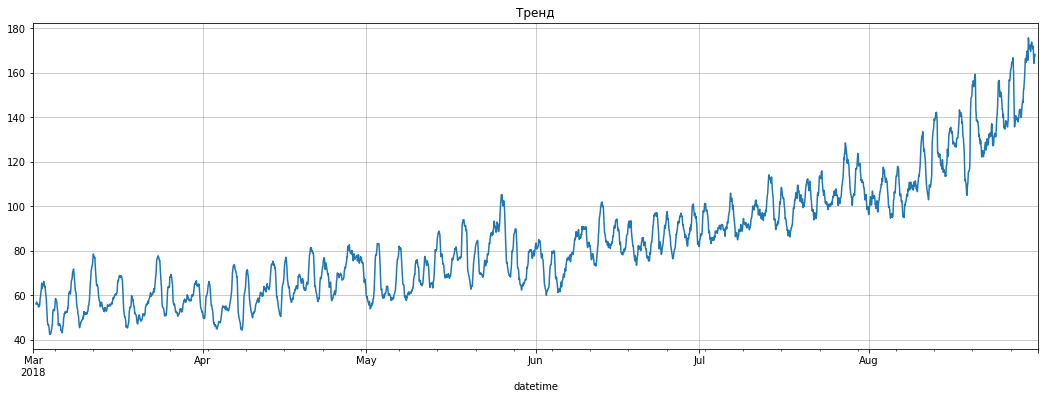

In [11]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(18, 6))
decomposed.trend.plot(ax=plt.gca())
plt.grid(color='grey', axis='both', alpha=0.5)
plt.title('Тренд')
plt.show()

### Сезонность

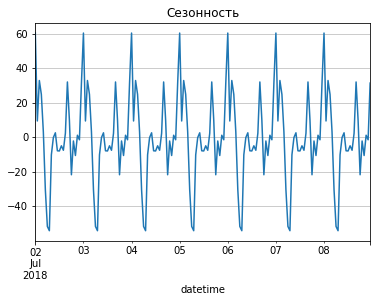

In [12]:
decomposed = seasonal_decompose(df['2018-07-02':'2018-07-08'])
decomposed.seasonal.plot(ax=plt.gca())
plt.grid(color='grey', axis='both', alpha=0.5)
plt.title('Сезонность')
plt.show()

Видна сезонность с периодом в один день, с  подъемом спроса к вечеру и спад к утру, при этом средние показатели днем.

### Количество заказов такси

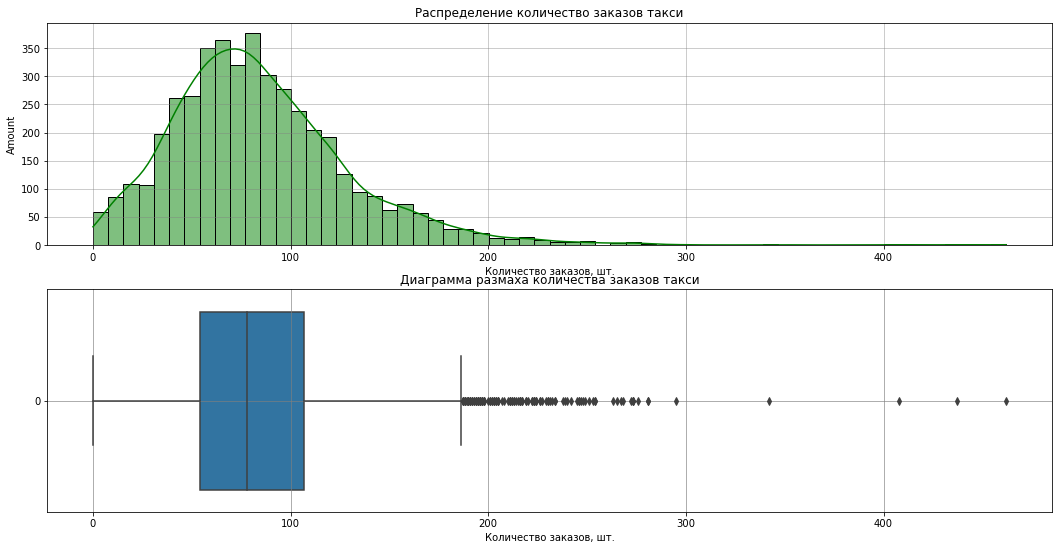

In [13]:
plt.figure(figsize=(18, 9))
plt.subplot(211)
sns.histplot(data=df, x='num_orders', kde=True, bins=60, color='green')
plt.title(f'Распределение количество заказов такси')
plt.ylabel('Amount')
plt.xlabel('Количество заказов, шт.')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.subplot(212)
sns.boxplot( data=df['num_orders'], orient="h" )
plt.title(f'Диаграмма размаха количества заказов такси')
plt.xlabel('Количество заказов, шт.')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Распределение нормальное, виден небольшой хвост с выбросами, трогатить их не будем ввиду, того, что максимальное количество заказов в пиковые часы нам тоже важны.

### Стационарность ряда

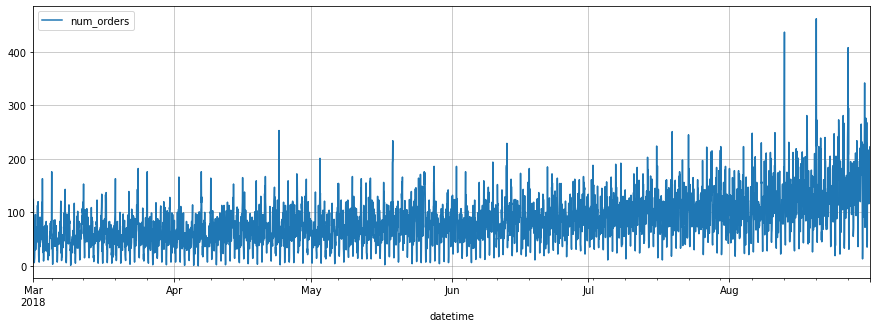

In [14]:
plt.rcParams["figure.figsize"] = (15, 5)
df.plot()
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

Ряд похож на стационарный.  
 Стоит сравнить средние значения и дисперсии.

In [15]:
X = df
split = len(X) / 2
X1, X2 = X['2018-03-01':'2018-06-01'], X['2018-06-02':'2018-08-31']
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=65.180556, mean2=104.087912
variance1=1084.163261, variance2=2226.325754


Имеется какая-то нестационарость, для уточнея проведем тест Дики-Фуллера:

Нулевая гипотеза теста состоит в том, что временной ряд может быть представлен единичным корнем, что он не является стационарным (имеет некоторую зависящую от времени структуру). Альтернативная гипотеза (отвергающая нулевую гипотезу) состоит в том, что временной ряд является стационарным.

- Нулевая гипотеза (H0): Если не удалось отклонить, он предполагает, что временной ряд имеет единичный корень, то есть он нестационарный. Он имеет некоторую временную структуру.
- Альтернативная гипотеза (H1): Нулевая гипотеза отвергается; он предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным. Он не имеет временной структуры.  

Мы интерпретируем этот результат, используя значение p из теста. Значение p ниже порогового значения (например, 5% или 1%) предполагает, что мы отвергаем нулевую гипотезу (стационарную), в противном случае значение p выше порогового значения указывает на то, что мы не можем отклонить нулевую гипотезу (нестационарную).  

- р-значение & gt; 0,05: Не удается отклонить нулевую гипотезу (H0), данные имеют единичный корень и являются нестационарными.
- р-значение & lt; = 0,05: Отклонить нулевую гипотезу (H0), данные не имеют единичного корня и являются стационарными.

[Ссылка](https://www.machinelearningmastery.ru/time-series-data-stationary-python/)

In [16]:
X = df['num_orders']

test = adfuller(X)

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical Values:')
for key, value in test[4].items():
    print('\t\t%s: %.3f' % (key, value))
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -3.0689242890279567
p-value:  0.02894005140261284
Critical Values:
		1%: -3.432
		5%: -2.862
		10%: -2.567
Единичных корней нет, ряд стационарен


### Создание признаков

Напишем функцию make_features():
- добавим четыре новых календарных признака: месяц, день, час, день недели;
- добавим отстающие значения;
- добавим скользящее среднее и скользящую медиану

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Получает data, 
    max_lag - глубина отстающих значений, 
    rolling_mean_size - размер выборки для скользящего среднего
    
    Создает признаки в data
    Первая часть выделяет календарные признаки (месяц/день etc.)
    Вторая добавляет отстающие значения
    Третья добавляет скользящее среднее и медианну
    '''
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_median'] = data['num_orders'].shift().rolling(rolling_mean_size).median()

In [18]:
make_features(df, 6, 12)

In [19]:
df.tail()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean,rolling_median
datetime,,,,,,,,,,,
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,163.416667,174.5
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,170.916667,174.5
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,168.583333,166.5
2018-08-31 22:00:00,223,4,22,159.0,154.0,136.0,207.0,217.0,197.0,164.916667,162.5
2018-08-31 23:00:00,205,4,23,223.0,159.0,154.0,136.0,207.0,217.0,167.583333,162.5


Вывод: данные подготовленыи. Приступаем к обучению.

## Обучение

### Разбиение данных на выборки

Разобьем данные: 90% - train set, 10% - test set:

In [20]:
df = df.dropna()
features = df.drop(columns=['num_orders'])
target = df['num_orders']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.1, shuffle=False)

In [22]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3963, 10) (441, 10)
(3963,) (441,)


In [23]:
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-01 12:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


### LinearRegression

In [24]:
%%time
start = time.time()

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

end = time.time()
lr_fit_time = end - start

Wall time: 0 ns


In [25]:
lr_predict = lr_model.predict(X_train)

In [26]:
lr_rsme = mean_squared_error(y_train, lr_predict) ** 0.5

### Extreme gradient boosting regressor

In [27]:
%%time
start = time.time()

xgbr = xgb.XGBRegressor(verbosity=0, random_state=42)
params = {'n_estimators': [50, 100, 150],
          'objective': ['reg:squarederror'],
          'learning_rate' : [0.1, 0.3],
          'max_depth': [3, 5]}
xgbr_model = GridSearchCV(estimator=xgbr, param_grid=params, n_jobs=-1, cv=TimeSeriesSplit(n_splits=6))
xgbr_model.fit(X_train, y_train)

end = time.time()
xgbr_search_time = end - start

Wall time: 5.56 s


In [28]:
xgbr_model.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 150,
 'objective': 'reg:squarederror'}

In [29]:
%%time

start = time.time()

xgbr_best_model = xgb.XGBRegressor(n_estimators=150, objective='reg:squarederror', learning_rate=0.3, max_depth=3)
xgbr_best_model.fit(X_train, y_train)

end = time.time()
xgbr_fit_time = end - start

Wall time: 136 ms


In [30]:
xgbr_predict = xgbr_best_model.predict(X_train)

In [31]:
xgbr_rsme = mean_squared_error(y_train, xgbr_predict) ** 0.5

### Light Gradient Boosting Machine

In [32]:
%%time
start = time.time()

gbm = lgb.LGBMRegressor()
params = {'num_leaves': [50, 100, 150],
          'learning_rate' : [0.1, 0.3, 0.5],
          'n_estimators': [100, 250],
         'metric': ['rmse']}
gbm_model = GridSearchCV(estimator=gbm, param_grid=params, n_jobs=-1, cv=TimeSeriesSplit(n_splits=6))
gbm_model.fit(X_train, y_train)

end = time.time()
gbm_search_time = end - start

Wall time: 6.72 s


In [33]:
gbm_model.best_params_

{'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 100, 'num_leaves': 50}

In [34]:
%%time
start = time.time()

gbm = lgb.LGBMRegressor(num_leaves=100, learning_rate=0.1, n_estimators=100, metric='rmse')
gbm.fit(X_train, y_train)

end = time.time()
gbm_fit_time = end - start

Wall time: 275 ms


In [35]:
gbm_predict = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [36]:
gbm_rsme = mean_squared_error(y_train, gbm_predict) ** 0.5

### Cat Boost Regressor

In [37]:
%%time
start = time.time()

CBR = CatBoostRegressor()

parameters = {'max_depth' : [3, 5],
              'learning_rate' : [0.01, 0.03],
              'iterations' :  [250, 500],
              'eval_metric' : ['RMSE']}

Grid_CBR = GridSearchCV(estimator=CBR, param_grid=parameters, cv=TimeSeriesSplit(n_splits=6), n_jobs=-1)
Grid_CBR.fit(X_train, y_train)

end = time.time()
cbr_search_time = end - start

0:	learn: 38.2397182	total: 163ms	remaining: 1m 21s
1:	learn: 37.7032405	total: 166ms	remaining: 41.3s
2:	learn: 37.2135467	total: 168ms	remaining: 27.9s
3:	learn: 36.7748328	total: 171ms	remaining: 21.2s
4:	learn: 36.3002741	total: 173ms	remaining: 17.2s
5:	learn: 35.9366234	total: 176ms	remaining: 14.5s
6:	learn: 35.5157920	total: 177ms	remaining: 12.5s
7:	learn: 35.0681544	total: 179ms	remaining: 11s
8:	learn: 34.6450934	total: 181ms	remaining: 9.86s
9:	learn: 34.2650500	total: 182ms	remaining: 8.93s
10:	learn: 33.9476588	total: 184ms	remaining: 8.18s
11:	learn: 33.6785293	total: 186ms	remaining: 7.55s
12:	learn: 33.3992426	total: 187ms	remaining: 7.01s
13:	learn: 33.0476204	total: 189ms	remaining: 6.55s
14:	learn: 32.7411258	total: 190ms	remaining: 6.16s
15:	learn: 32.4581797	total: 192ms	remaining: 5.81s
16:	learn: 32.1788230	total: 194ms	remaining: 5.5s
17:	learn: 31.9265374	total: 195ms	remaining: 5.23s
18:	learn: 31.6909365	total: 197ms	remaining: 4.98s
19:	learn: 31.4406667	to

In [38]:
Grid_CBR.best_params_

{'eval_metric': 'RMSE',
 'iterations': 500,
 'learning_rate': 0.03,
 'max_depth': 5}

In [39]:
%%time
start = time.time()

cbr_best_model = CatBoostRegressor(eval_metric='RMSE', 
                                   iterations=500, learning_rate=0.03, 
                                   max_depth=5)
cbr_best_model.fit(X_train, y_train)
end = time.time()
cbr_fit_time = end - start

0:	learn: 38.2397182	total: 46.9ms	remaining: 23.4s
1:	learn: 37.7032405	total: 49.3ms	remaining: 12.3s
2:	learn: 37.2135467	total: 51.8ms	remaining: 8.57s
3:	learn: 36.7748328	total: 54.3ms	remaining: 6.73s
4:	learn: 36.3002741	total: 56.5ms	remaining: 5.59s
5:	learn: 35.9366234	total: 58.9ms	remaining: 4.85s
6:	learn: 35.5157920	total: 60.9ms	remaining: 4.29s
7:	learn: 35.0681544	total: 62.6ms	remaining: 3.85s
8:	learn: 34.6450934	total: 64.2ms	remaining: 3.5s
9:	learn: 34.2650500	total: 65.8ms	remaining: 3.22s
10:	learn: 33.9476588	total: 67.3ms	remaining: 2.99s
11:	learn: 33.6785293	total: 68.8ms	remaining: 2.8s
12:	learn: 33.3992426	total: 70.5ms	remaining: 2.64s
13:	learn: 33.0476204	total: 72.1ms	remaining: 2.5s
14:	learn: 32.7411258	total: 73.8ms	remaining: 2.39s
15:	learn: 32.4581797	total: 75.8ms	remaining: 2.29s
16:	learn: 32.1788230	total: 77.7ms	remaining: 2.21s
17:	learn: 31.9265374	total: 79.5ms	remaining: 2.13s
18:	learn: 31.6909365	total: 81.1ms	remaining: 2.05s
19:	le

In [40]:
cbr_predict = cbr_best_model.predict(X_train)

In [41]:
cbr_rmse = mean_squared_error(y_train, cbr_predict) ** 0.5

## Тестирование

### Предсказания

In [42]:
# Linear Regression
lr_predict = lr_model.predict(X_test)
lr_rsme_test = mean_squared_error(y_test, lr_predict) ** 0.5
# Extreme gradien boosting regressor
xgbr_predict = xgbr_best_model.predict(X_test)
xgbr_rsme_test = mean_squared_error(y_test, xgbr_predict) ** 0.5
# light gradien boosting machine
gbm_predict = gbm.predict(X_test)
gbm_rsme_test = mean_squared_error(y_test, gbm_predict) ** 0.5
# Cat Boost regressor
cbr_predict = cbr_best_model.predict(X_test)
cbr_rmse_test = mean_squared_error(y_test, cbr_predict) ** 0.5

In [43]:
model_results = {
                'RMSE test score': [lr_rsme_test, xgbr_rsme_test, gbm_rsme_test, cbr_rmse_test],
                'RMSE train score': [lr_rsme, xgbr_rsme, gbm_rsme, cbr_rmse],
                'Search time, sec': ['NaN', xgbr_search_time, gbm_search_time, cbr_search_time],
                'Fit time, sec': [lr_fit_time, xgbr_fit_time, gbm_fit_time, cbr_fit_time]
                 }

In [44]:
results = pd.DataFrame(data=model_results, index=('Linear Regression', 'XGBoost', 'LightGBM', 'Catboost'))
results

,RMSE test score,RMSE train score,"Search time, sec","Fit time, sec"
Linear Regression,52.679353,31.090388,NaN,0.000000
XGBoost,47.266744,16.761398,5.561425,0.135960
LightGBM,44.843525,8.704801,6.717372,0.275062
Catboost,45.371571,20.424528,10.622285,0.990959


Проверка:

In [45]:
predictions = pd.DataFrame(data = cbr_predict, index = y_test.index)

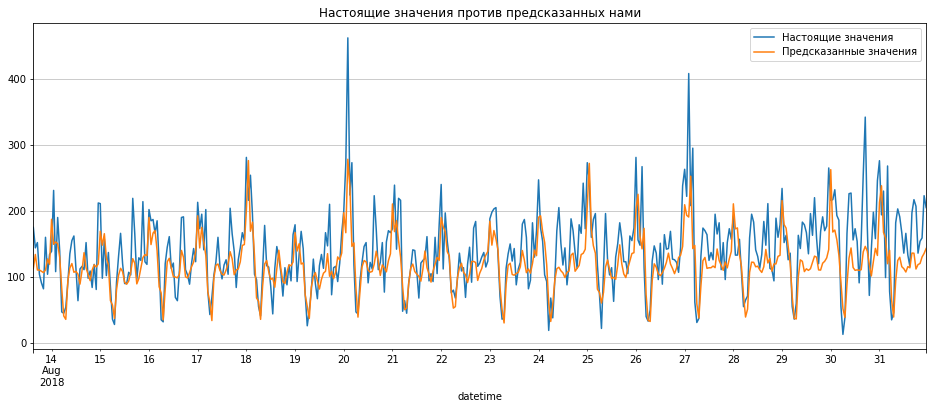

In [46]:
plt.figure(figsize=(16, 6))
y_test['2018-08-13':'2018-08-31'].plot(ax=plt.gca())
predictions['2018-07-13':'2018-08-31'].plot(ax=plt.gca())
plt.title('Настоящие значения против предсказанных нами')
plt.legend(['Настоящие значения', 'Предсказанные значения'])
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

Вывод

- Модели обученные нами имеют тенденецию к переобучению, при этом на тестовой выборке RMSE получено согласно условию.
- Лучшая RMSE показала модель Catbosot = 45.37.
- Можель немного занижает прогноз в пиковые часы.